<a href="https://colab.research.google.com/github/sheniabosch/9.House_Price_Predictions/blob/main/KaggleRock_Regression_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

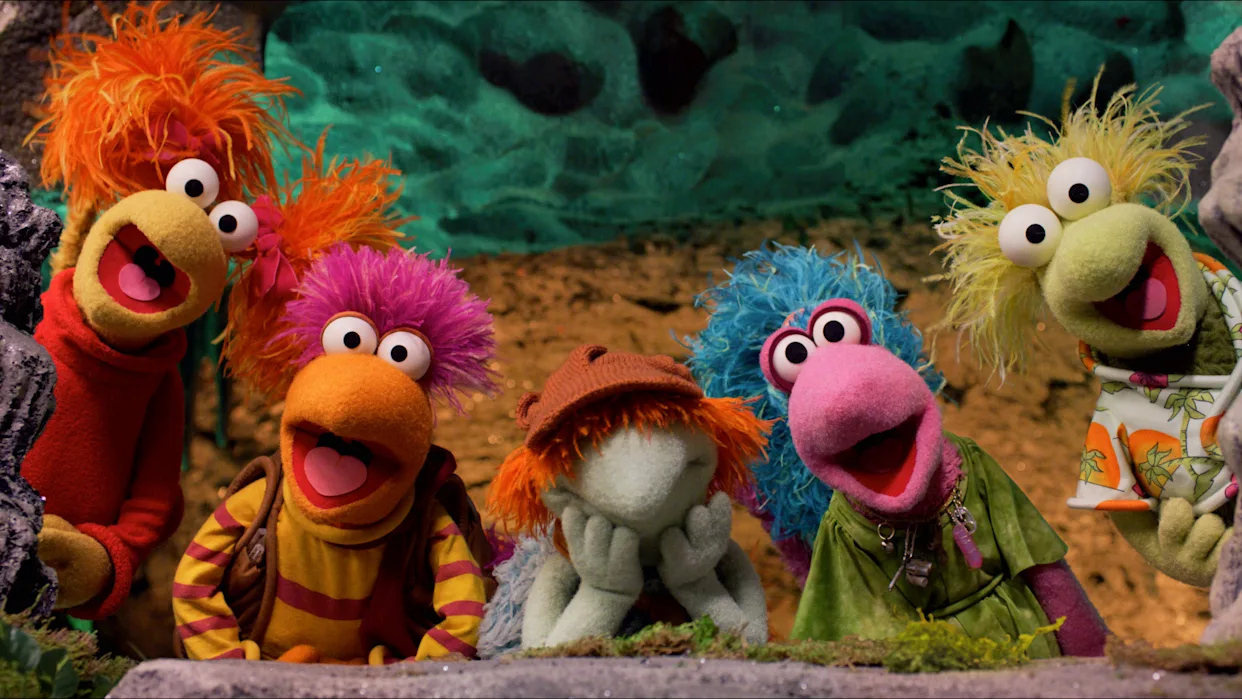

# 🏠 **House Price Prediction Project Summary**

**Overview**

This project predicts house prices using a machine learning pipeline in Python. It employs advanced feature engineering, preprocessing, and a stacking ensemble of regression models for accurate predictions. The dataset is sourced from a Kaggle competition, processing both training and test data to generate a submission file.

---

**Features**


* Data Preprocessing: Handles numerical, ordinal, and nominal categorical
features with imputation, scaling, and encoding.


* Feature Engineering: Creates features like TotalSF, TotalPorchSF, TotalBath, HouseAge, and interaction terms to enhance model performance.


* Model: Utilizes a stacking regressor combining Linear Regression, Random Forest, XGBoost, LightGBM, and CatBoost, with Ridge regression as the final estimator.


* Evaluation: Uses metrics like RMSE, R², RMSLE, and MAPE to assess model performance.


* Pipeline: Integrates preprocessing and modeling into a single scikit-learn pipeline for reproducibility and scalability.

---

**Requirements**


* Python 3.x


* Libraries: pandas, numpy, scikit-learn, xgboost, lightgbm, catboost


* Dataset: Training and test data from provided Kaggle

---


**Usage**


1. Load and split the training data.

2. Preprocess numerical and categorical features using a ColumnTransformer.

3. Apply custom feature engineering to create new features.

4. Train a stacking ensemble model using cross-validation.

5. Evaluate the model on training and test sets.

6. Generate predictions for the test dataset and save them to KaggleRock7.csv.


---


**Results**

The model is evaluated using cross-validation and achieves competitive performance, as measured by RMSLE, RMSE, R², and MAPE on both training and test sets. The final predictions are saved for submission to Kaggle.


---


**Notes**


* The pipeline is optimized using GridSearchCV with a custom RMSLE scorer.


* The code is designed to handle missing values and categorical variables robustly.


* The stacking ensemble combines multiple models to improve prediction accuracy.

## 📚 Data and Libraries

## 📦 Imports and Libraries



In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import (train_test_split, cross_val_score,
 KFold, GridSearchCV)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,
  OneHotEncoder)

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import (RandomForestRegressor,
RandomForestRegressor, StackingRegressor)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (root_mean_squared_error, r2_score,
  mean_absolute_error, root_mean_squared_log_error,
  mean_absolute_percentage_error, accuracy_score, f1_score)

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
!pip install catboost
from catboost import CatBoostRegressor

from sklearn import set_config

set_config(transform_output="pandas")

### 🏋️ Loading the training data

In [ ]:
url = "https://drive.google.com/file/d/1BE0Yz2H6CY-YDvYKmS1rb7Sp1NJ1Q0_Z/view?usp=sharing"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
train_data = pd.read_csv(path)

In [ ]:
X=train_data.drop("Id",axis=1)

In [ ]:
y = X.pop("SalePrice")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=123)

### 🔪 Train/Test Split

### 🎯 Loading the test data
and pop the id column

In [ ]:
url = "https://drive.google.com/file/d/1612QVtzVPLjJIchn7oWjdJzFrox639XZ/view?usp=sharing"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
test_data = pd.read_csv(path)

In [ ]:
id_column = test_data.pop('Id')

## ⚙️ Pre-Processing

### ✨ Feature Categorization

In [ ]:
numerical_features = ['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
                      'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'OverallQual',
                      'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
                      'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
                      'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenAbvGr',
                      'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'OpenPorchSF', 'EnclosedPorch',
                      '3SsnPorch', 'MiscVal', 'MoSold', 'YrSold', 'OverallCond']

ordinal_categorical_features = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                               'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'FireplaceQu',
                               'Utilities', 'LandSlope', 'BsmtFinType2', 'HeatingQC',
                               'GarageFinish', 'GarageQual', 'GarageCond',
                               'PavedDrive', 'PoolQC', 'Fence']

nominal_categorical_features = ['MSZoning', 'Condition1', 'Heating', 'Street', 'CentralAir',
                                'Foundation', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
                                'Neighborhood', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
                                'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Electrical',
                                'Functional', 'GarageType', 'MiscFeature', 'SaleType',
                                'SaleCondition', 'MSSubClass']

# --- 4. Define OrdinalEncoder mappings ---
qual_with_na = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
qual_without_na = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
exposure_with_na = ['NA', 'No', 'Mn', 'Av', 'Gd']
bsmtfin_with_na = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
utilities_without_na = ['ELO', 'NoSeWa', 'NoSewr', 'AllPub']
landslope_without_na = ['Gtl', 'Mod', 'Sev']
garagefinish_with_na = ['NA', 'Unf', 'RFn', 'Fin']
paved_without_na = ['N', 'P', 'Y']
pool_with_na = ['NA', 'Fa', 'TA', 'Gd', 'Ex']
fence_with_na = ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']

ordinal_categories = [
    qual_without_na, qual_without_na, qual_with_na, qual_with_na,
    exposure_with_na, bsmtfin_with_na, qual_without_na, qual_with_na,
    utilities_without_na, landslope_without_na, bsmtfin_with_na, qual_without_na,
    garagefinish_with_na, qual_with_na, qual_with_na, paved_without_na,
    pool_with_na, fence_with_na
]



### ➡️ Pre-processor Pipeline

In [ ]:
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('encoder', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1))
])

nominal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('ord', ordinal_pipeline, ordinal_categorical_features),
        ('nom', nominal_pipeline, nominal_categorical_features)
    ],
    remainder='drop'
)
preprocessor.set_output(transform="pandas")
tuned_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('Regressor', LogisticRegression())])

### ✍️ Feature Engineeering

In [ ]:
class AdvancedFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
        X['TotalPorchSF'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['3SsnPorch'] + X['ScreenPorch']
        X['TotalBath'] = X['FullBath'] + (0.5 * X['HalfBath']) + X['BsmtFullBath'] + (0.5 * X['BsmtHalfBath'])
        X['HouseAge'] = X['YrSold'] - X['YearBuilt']
        X['Remodeled'] = np.where(X['YearBuilt'] != X['YearRemodAdd'], 1, 0)
        X['IsNew'] = np.where(X['YrSold'] == X['YearBuilt'], 1, 0)
        X['HasPool'] = np.where(X['PoolArea'] > 0, 1, 0)
        X['Has2ndFloor'] = np.where(X['2ndFlrSF'] > 0, 1, 0)
        X['HasGarage'] = np.where(X['GarageArea'] > 0, 1, 0)
        X['HasBsmt'] = np.where(X['TotalBsmtSF'] > 0, 1, 0)
        X['HasFireplace'] = np.where(X['Fireplaces'] > 0, 1, 0)
        # New feature: Quality-Living interaction
        X['Qual_Liv'] = X['OverallQual'] * X['GrLivArea']
        # Log-transform skewed
        skewed_feats = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                        '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF',
                        'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
        for feat in skewed_feats:
            if feat in X.columns:
                X[feat] = np.log1p(X[feat])
        X['OverallQual_squared'] = X['OverallQual'] ** 2
        X['GrLivArea_squared'] = X['GrLivArea'] ** 2
        X['GarageCars_squared'] = X['GarageCars'] ** 2
        return X

# Update numerical_features
new_numerical_features = ['TotalSF', 'TotalPorchSF', 'TotalBath', 'HouseAge', 'Remodeled', 'IsNew',
                          'HasPool', 'Has2ndFloor', 'HasGarage', 'HasBsmt', 'HasFireplace',
                          'OverallQual_squared', 'GrLivArea_squared', 'GarageCars_squared', 'Qual_Liv']
numerical_features_updated = numerical_features + new_numerical_features

# Update preprocessor with new numerical_features
preprocessor_updated = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features_updated),
        ('ord', ordinal_pipeline, ordinal_categorical_features),
        ('nom', nominal_pipeline, nominal_categorical_features)
    ],
    remainder='drop'
)


In [ ]:
full_preprocessor = Pipeline(steps=[
    ('feature_engineer', AdvancedFeatureEngineer()),
    ('preprocessor', preprocessor_updated)
])


## 🧠 Defining Models

### 🥞 Model Stack

In [ ]:
# Define base models for stacking (regression models)
base_models = [
    ('linreg', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=5, subsample=0.7, colsample_bytree=0.7, random_state=42)),
    ('lgbm', LGBMRegressor(n_estimators=500, learning_rate=0.1, num_leaves=25, random_state=42)),
    ('cat', CatBoostRegressor(iterations=500, learning_rate=0.1, depth=5, verbose=0, random_state=42))
]

# Stacking regressor
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(random_state=42),
    cv=3,
    n_jobs=-1
)

# Full pipeline
tuned_pipeline = Pipeline(steps=[
    ('full_preprocessor', full_preprocessor),
    ('regressor', stacking_model)
])


In [ ]:
tuned_pipeline

Pipeline(steps=[('full_preprocessor',
                 Pipeline(steps=[('feature_engineer',
                                  AdvancedFeatureEngineer()),
                                 ('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['LotArea',
                                                                    'LotFrontage',
                                                                    'TotalBsmtSF',
                                                                    'BedroomAbvGr',
                                                                    'Fireplaces',
                                                                    'PoolArea',
                                                                    'GarageCars',
                                                                    'WoodDeckSF',
                                                                    'ScreenPorch',
                                                                    'Ov...
                                                             max_depth=5,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=500,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...)),
                                               ('lgbm',
                                                LGBMRegressor(n_estimators=500,
                                                              num_leaves=25,
                                                              random_state=42)),
                                               ('cat',
                                                <catboost.core.CatBoostRegressor object at 0x7d560010fec0>)],
                                   final_estimator=Ridge(random_state=42),
                                   n_jobs=-1))])

### 🚀 Optimise the model parameters (GridSearchCV)

In [ ]:
from sklearn.metrics import make_scorer
rmsle_scorer = make_scorer(root_mean_squared_log_error, greater_is_better=False)
cv_scores = cross_val_score(tuned_pipeline, X_train, y_train, cv=3, scoring=rmsle_scorer)

print(f'Mean CV RMSLE: {-cv_scores.mean():.4f} (± {cv_scores.std():.4f})')

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


Mean CV RMSLE: 0.1315 (± 0.0067)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


## 🚂 Train the model

In [ ]:
tuned_pipeline.fit(X, y)
y_pred_unlabeled_tuned = tuned_pipeline.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


### 🤔 Evaluate the model

In [ ]:
train_pred = tuned_pipeline.predict(X_train)
test_pred = tuned_pipeline.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


### 🏆 Accuracy Evaluation

In [ ]:
train_rmse = root_mean_squared_error(y_train, train_pred)
test_rmse = root_mean_squared_error(y_test, test_pred)
train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)
train_rmsl = root_mean_squared_log_error(y_train, train_pred)
test_rmsl = root_mean_squared_log_error(y_test, test_pred)
train_map = mean_absolute_percentage_error(y_train, train_pred)
test_map = mean_absolute_percentage_error(y_test, test_pred)


print(f'Model Train MAP: {train_map:.2f}')
print(f'Model Test MAP : {test_map:.2f}\n')
print(f'Model Train r2: {train_r2:.2f}')
print(f'Model Test r2 : {test_r2:.2f}\n')
print(f'Model Train RMSE: {train_rmse:.2f}')
print(f'Model Test RMSE : {test_rmse:.2f}\n')
print(f'Model Train RMSL: {train_rmsl:.2f}')
print(f'Model Test RMSL : {test_rmsl:.2f}\n')

Model Train MAP: 0.02
Model Test MAP : 0.02

Model Train r2: 1.00
Model Test r2 : 1.00

Model Train RMSE: 5224.96
Model Test RMSE : 5244.28

Model Train RMSL: 0.03
Model Test RMSL : 0.03



## 🚂 Retrain the model on the full train dataset

In [ ]:
tuned_pipeline.fit(X,y)

Pipeline(steps=[('full_preprocessor',
                 Pipeline(steps=[('feature_engineer',
                                  AdvancedFeatureEngineer()),
                                 ('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['LotArea',
                                                                    'LotFrontage',
                                                                    'TotalBsmtSF',
                                                                    'BedroomAbvGr',
                                                                    'Fireplaces',
                                                                    'PoolArea',
                                                                    'GarageCars',
                                                                    'WoodDeckSF',
                                                                    'ScreenPorch',
                                                                    'Ov...
                                                             max_depth=5,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=500,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...)),
                                               ('lgbm',
                                                LGBMRegressor(n_estimators=500,
                                                              num_leaves=25,
                                                              random_state=42)),
                                               ('cat',
                                                <catboost.core.CatBoostRegressor object at 0x7d560010fec0>)],
                                   final_estimator=Ridge(random_state=42),
                                   n_jobs=-1))])

### 🔮 Make predictions on test data

In [ ]:
predictions = tuned_pipeline.predict(test_data)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [ ]:
results = pd.DataFrame({
    'Id':id_column,
    'SalePrice':predictions
})

In [ ]:
results

,Id,SalePrice
0,1461,121693.155297
1,1462,163027.961053
2,1463,191194.641636
3,1464,196359.324982
4,1465,181217.831071
...,...,...
1454,2915,76989.091471
1455,2916,71759.549712
1456,2917,154564.343519
1457,2918,118068.127315


### 📤 File Submission to CSV

In [ ]:

results.to_csv('KaggleRock7.csv',index=False)
